## Radial Basis Functions

### RBF Classifier

K-means clustering

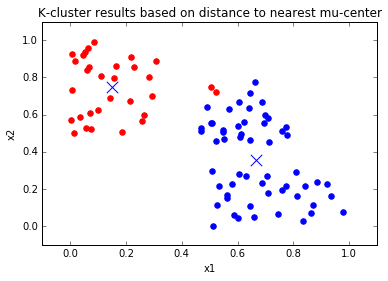

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def k_means_clstr(X, K, tolerance=0.0001, max_iterations=100):
    
    #initialize mu_centers 
    mu_centers = {}
    for k in range(K):
        mu_centers[k] = X[k]

    #run main loop until mu center stop shifting
    for iter_ in range(max_iterations):
        
        # initialize S_k clusters
        S = {}
        for k in range(K):
            S[k] = []
            
        # build clusters based on distance between point and nearest mu_center
        for point in X:
            distances = [np.linalg.norm(point - mu_centers[mu_center]) 
                         for mu_center in mu_centers]
            k = distances.index(min(distances))
            S[k].append(point)
            
        # maintain a record of mu-centers prior to computing mean
        previous = dict(mu_centers)

        # compute mean of each cluster
        for k in S:
            mu_centers[k] = np.average(S[k], axis = 0)
            
        # initialize boolean as True
        optimal = True
        
        # check if there was a shift in mu_centers
        for k in range(K):
            shift = np.linalg.norm(mu_centers[k] - previous[k])
            if shift > tolerance:
                optimal = False

        # break when mu_centers stop shifting
        if optimal:
            return S, mu_centers
        
    print 'maximum number of iterations:', iter_

#load input and plot cluster points
df = pd.read_csv('ipl.csv')
X = df.values
K = 2
S, mu_centers = k_means_clstr(X, K)
colors = ['r', 'b', 'k']
for mu_center in mu_centers:
    plt.scatter(mu_centers[mu_center][0], mu_centers[mu_center][1], s = 130, marker = "x")
for k in S:
    color = colors[k]
    for points in S[k]:
        plt.scatter(points[0], points[1], color = color, s = 30)
axes = plt.gca()
axes.set_xlim([-0.1, 1.1]) 
axes.set_ylim([-0.1, 1.1]) 
plt.title('K-cluster results based on distance to nearest mu-center')
plt.xlabel('x1')
plt.ylabel('x2')

RBF (K-centers) Classifier<br>(results: some +1 class points get clustered with the -1 class) 

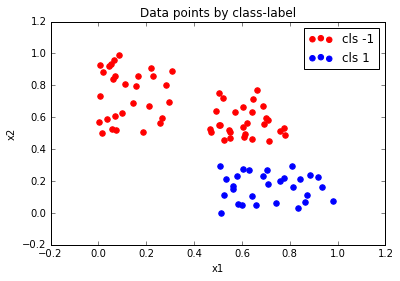

A few points in -1 class happened to be clustered within the other mu-center.
Attempt to learn a value for gamma, that can scoop up some of those points.


In [6]:
# continue above example by assigning labels to points
y = []
for point in X:
    if point[1] > 0.3:  
        y.append(-1)
    else:
        y.append(1)
y = np.array(y)

# plot by classes
r = len(X)
plt.scatter([X[i][0] for i in range(r) if y[i]==-1], 
            [X[i][1] for i in range(r) if y[i]==-1], color='r', s=30, label='cls -1')
plt.scatter([X[i][0] for i in range(r) if y[i]== 1], 
            [X[i][1] for i in range(r) if y[i]== 1], color='b', s=30, label='cls 1')
plt.title('Data points by class-label')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()
print 'A few points in -1 class happened to be clustered within the other mu-center.'
print 'Attempt to learn a value for gamma, that can scoop up some of those points.'

### RBF Networks
Phi-activated hidden layer neurons<br>results compared with least squares regression (closed form solution)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def kMeans(X, K, c, tolerance=0.00001, max_t=20, verbose=True):
    '''
    Parameters
      X          - training set inputs
      K          - number of clusters selected by user
      c          - category, or output-class, number (for messaging purposes only)
      tolerance  - threshold with respect to determination of a shift in μ-centers
      max_t      - maximum number of iterations, typically the function breaks well
                   before this limit is attained
      verbose    - if set to True, the # of iterations completed will be displayed
                   each time function is called by train function
      
    Returns 
      mu_centers - dict key is cluster #, value is μ-vector 
      S          - dict key is cluster #, value is matrix of member points
    '''
    #initialize mu_centers dictionary 
    mu_centers = {}
    for k in range(K):
        mu_centers[k] = X[k]

    #run main loop until mu center stops shifting
    for t in range(max_t):
        
        # copy value of mu_centers dictionary
        previous = dict(mu_centers)

        # initialize S_k clusters
        S = {}
        for k in range(K):
            S[k] = []
            
        # build clusters based on distance between point and nearest mu_center
        for point in X:
            distances = [np.linalg.norm(point - mu_centers[mu_center]) 
                         for mu_center in mu_centers]
            k = distances.index(min(distances))
            S[k].append(point)

        # compute mean of each cluster
        for k in S:
            mu_centers[k] = np.average(S[k], axis = 0)
            
        # initialize boolean as True
        optimal = True
        
        # check if there was a shift in mu_centers
        for k in range(K):
            shift = np.linalg.norm(mu_centers[k] - previous[k])
            if shift > tolerance:
                optimal = False

        # break when mu_centers stop shifting
        if optimal:
            for k in range(K):
                if len(S[k]) < 2:
                    print 'Note: cluster', k, 'has fewer than 2 members'
            if verbose:
                print '\noutput-class:', c, '\n# of iterations in kMeans:', t
            return mu_centers, S
        
    print '\nno convergence after', t, 'iterations'
    
def predict(p, betas, centers, weights):
    '''
    Propogates through an RBF network (as defined by betas and centers) 
    on point p, and weights passed in from an iteration within gradient 
    descent training, or in connection with predict/testing.  Activates a 
    Φ-vector, and computes output.  
    
    Parameters
      p               -  point on which prediction is to be made
      betas, centers  -  vector of betas, matrix of mu-centers (model data)
      weights         -  weights in connection with predict/testing, or w(t) 
                         from gradient descent iterations
    
    Returns
      prediction      -  real-valued output based on Φ-vector dotted with w(t)
    '''
    # Φ-activation on point p
    distances = np.linalg.norm(p - centers, axis=1)
    phi_actv = np.exp(- betas * distances ** 2) 
    phi_actv = np.insert(phi_actv, 0, 1.0) # add threshold to Φ-vector

    # output based on Φ-activation and w(t)
    pred = np.dot(phi_actv, weights)
    return pred

def SGD(X, y, phi, betas, centers, eta=0.01, numEpochs=200, lmbda=0.001):
    '''
    Parameters
      X, y                 - training set inputs and labels
      phi                  - matrix of Φ-activations 
                               axis-0 aligns with network hidden layer 
                               axis-1 aligns with points in training set
      betas, centers       - model data passed along to prediction function
      eta                  - η, learning rate
      numEpochs            - maximum number of training cycle iterations
      lmbda                - regularization parameter
                               
    Returns
      epochs-weights       - weights vector results, one per training cycle
     '''
    # initialize list for storing weights upon each epoch
    w_epchs = []
    
    #initialize a weights vector (size to match number of Φ-matrix columns)
    d = len(phi[0])   
    w = np.array([ np.random.random() for i in range(d) ])
 
    #create a row index for data points in training set
    idx = list(range(len(X)))
    
    #training cycle loop
    for t in range(numEpochs):
        
        #loop over training points in random order
        np.random.shuffle(idx)
        for p in idx:
            
            #propogate network on new point p and new w, compute error
            pred = predict(np.array(X[p]), betas, centers, w)
            error = y[p] - pred
            
            #if error on single point is positive, all w's increase,
            #if error on single point is negative, all w's decrease,
            # ... in relation to Φ_i
            w[0] = w[0] + eta * error  # update threshold
            for i in range(1, d): 
                # w_i(t+1) = w_i(t) + η ⋅ (y_p − y_pred) ⋅ Φ_i
                w[i] = w[i] + eta * error * phi[p][i] 
        
        #store current weights using list comprehension
        w_epchs.append( [ wi for wi in w ] ) 
                 
    return w_epchs 

def accuracy_metric(actual, predicted):
    '''
    Parameters
      actual              - vector of target values
      predicted           - vector of predicted values
      
    Returns
      accuracy-result     - percentage of correct predictions
    '''
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    accuracy_result = correct / float(len(actual)) * 100.
    return accuracy_result
     
def train_RBFN(X, y, centersPerCategory, verbose=True):
    '''
    Model is trained using two methods (1) a least squares closed-form solution 
    using pseudo-inverse† of Φ, and (2) stochastic gradient descent
    
    Parameters
      X                    - training set inputs
      y                    - training set labels
      centersPerCategory   - centers/clusters per class
      verbose              - if set to True, certain network details are displayed      
    
    Network details
      size of input layer  - number of input features plus one
      size of hidden layer - (centers-per-category * output-classes) plus one
      size of output layer - one (regardless of # of output-classes) 
      number of betas      - centers-per-category * output-classes
      output weights       - N: separately computed per output class
                             d: # of hidden neurons plus one (or numHiddenNodes)
                                                           
    Returns
      betas                - vector of betas (one real value per hidden neuron)
                             applies to gaussian width
      ctrs_matrx           - matrix of mu-centers (one vector per cluster)
      w_least_sqs          - weights results from closed-form solution
                             shape(numCats, numHiddenNodes)
      w_epochs             - weights results from gradient descent
                             1 w-vector per training cycle, per output-class
                             shape(numCats, numEpochs, numHiddenNodes)
    '''
    # initialize
    betas, ctrs_matrx, w_least_sqs, w_epochs = [], [], [], []
    
    if verbose:
        print 'number of training points:', len(X)
    
    # loop through categories(classes)
    numCats = len(np.unique(y))
    for c in range(numCats):
        
        # run kMeans to form category-c clusters
        Xc = [ X[p] for p in range(len(X)) if y[p]==c ]
        centers, memberships = kMeans(Xc, centersPerCategory, c)
        
        if verbose:
            for i in range(len(memberships)):
                print 'center:', centers[i], 
                print 'cluster size:', len(memberships[i])
         
        # compute sigma σ and beta β for each center
        #        1    m                               1
        #   σ = --- ⋅ ∑  ⋅ ||x_i - μ||          β =  ----    
        #        m   i=1                            2 σ^2   
        for ci in range(len(centers)): 
            center = centers[ci]
            ctrs_matrx.append(center) # build centers-matrix
            members = memberships[ci]
            sigma = sum(np.linalg.norm(members - center, axis=1)) / len(members)
            beta  =  1.0 / 2.0 * sigma ** 2 
            betas.append(beta)
    
    #convert to array
    betas, ctrs_matrx = np.array(betas), np.array(ctrs_matrx)
            
    # Φ-activatation ( exp^(-β⋅‖x − μ_k‖^2) ) for hidden neurons
    distances = np.linalg.norm(X[:, np.newaxis] - ctrs_matrx[np.newaxis, :], axis=2)
    phi = np.exp(- betas * distances ** 2)
    
    # add threshold node to hidden layer, by adding threshold parameter to Φ-matrix
    col = np.array([1.0] * len(phi))
    phi = np.concatenate((col[:, np.newaxis], phi), axis=1)
    
    if verbose:
        print '\nbetas:\n', betas
        print '\nphi-matrix (1st row):\n', phi[0]
        print 'number of rows in phi-matrix:', len(phi)
        
    # set yc to 1 for category 'c', 0 for other
    for c in range(numCats):
        yc = []  
        for i in range(len(y)):
            target = 0
            if y[i]==c: 
                target = 1
            yc.append(target) 
            
        # use Φ† to compute weights
        w = np.dot(np.linalg.pinv(phi), yc)
        w_least_sqs.append( w.tolist() )
        
        # use stochastic gradient descent (pocket algorithm)
        wts = SGD(X, yc, phi, betas, ctrs_matrx)
        w_epochs.append(wts)

    if verbose:
        print '\nleast squares solution'
        for c in range(numCats):
            print 'weights, class', c, ':', 
            print [ round(wi, 3) for wi in w_least_sqs[c] ]                  
        print '\ngradient descent'
        for c in range(numCats):
            print 'weights at final epoch, class', c, ':',
            print [ round(wi,3) for wi in w_epochs[c][-1] ]
        print 'number of epochs:', np.array(w_epochs).shape[1]
           
    #return 
    return betas, ctrs_matrx, w_least_sqs, w_epochs

# Main

# set random.seed
np.random.seed(3)
                
# create points to be used for class-0
npoints, X1, X2 = 50, [], []
X1.append(np.random.uniform(low=0.0, high=2.4, size=npoints))   
X2.append(np.random.uniform(low=0.0, high=2.4, size=npoints))

# create points to be used for class-1
X1.append(np.random.uniform(low=1.2, high=3.6, size=npoints))
X2.append(np.random.uniform(low=1.2, high=3.6, size=npoints))

# create dataset and labels
X, y = [], []
for i in range(2):
    points = zip( X1[i], X2[i] )
    for p in points:
        X.append( [p[0], p[1]] )
    for n in range(npoints):
        y.append(i)
        
# add threshold parameter     
d = len(X[0])
X = np.array( [ [1.0] + x[:d] for x in X ] )

# train, test splits
indices = range(len(X))
XTest   = np.array([X[i] for i in indices if i%3 == 0])
XTrain  = np.array([X[i] for i in indices if i%3 != 0])
yTest   = np.array([y[i] for i in indices if i%3 == 0])
yTrain  = np.array([y[i] for i in indices if i%3 != 0])

# train
centersPerClass = 3
verbose = True
betas, centers, w_least_sqs, w_epochs = train_RBFN(XTrain, yTrain, 
                                                   centersPerClass, verbose)
# test (least squares solution)  
if verbose:
    print '\nnumber of testing points:', len(XTest)
numCats = len(np.unique(y))
preds = [ [] for i in range(numCats) ] 
preds_least_sqs = []
for c in range(numCats):
    for point in XTest:
        predval = predict( point, betas, centers, w_least_sqs[c] )
        preds[c].append(predval)
preds = np.array(preds)  #preds-shape(numCats, number-of-test-points)
for predvec in preds.T:  #preds.T-shape(number-of-test-points, numCats) 
    preds_least_sqs.append( np.argmax(predvec) )  #store index of highest result
accuracy_least_sqs = accuracy_metric( yTest, preds_least_sqs )
        
# test (gradient descent) - compute an accuracy score upon each epoch 
preds = [ [] for i in range(numCats) ] 
accuracy_SGD = []
numEpochs = np.array(w_epochs).shape[1]
for c in range(numCats):
    for t in range(numEpochs):
        for point in XTest:
            # compute output on test point and weights applicable to epoch & category
            predval = predict( point, betas, centers, w_epochs[c][t] )
            # append output to category index of (preds) list
            preds[c].append(predval) 
preds = np.array(preds) # preds shape is: (numCats, maxrange)          
for predvec in preds.T: # preds.T-shape is: (maxrange, numCats), (loop thru pred-vecs)
    preds_least_sqs.append( np.argmax(predvec) ) # store index of highest result
numTestPoints = len(XTest)
start, end = 0, numTestPoints  # initalize start and end ranges
maxrange = numEpochs * numTestPoints
while end <= maxrange:
    score = accuracy_metric( yTest, preds_least_sqs[start:end] )
    accuracy_SGD.append(score)
    start += numTestPoints # update start-point with respect to next epoch
    end += numTestPoints # update end-point with respect to next epoch

number of training points: 66

output-class: 0 
# of iterations in kMeans: 6
center: [ 1.          0.8964668   0.47562586] cluster size: 8
center: [ 1.          0.73957075  1.53198616] cluster size: 17
center: [ 1.          1.93966769  0.68433418] cluster size: 8

output-class: 1 
# of iterations in kMeans: 2
center: [ 1.          1.80355128  2.34379129] cluster size: 18
center: [ 1.          2.9687603   3.32046056] cluster size: 9
center: [ 1.          3.18070327  1.61337536] cluster size: 6

betas:
[ 0.07335531  0.09507484  0.09893201  0.27374545  0.05411253  0.04969411]

phi-matrix (1st row):
[ 1.          0.95378704  0.82516317  0.99034511  0.38654705  0.59289146
  0.8415744 ]
number of rows in phi-matrix: 66

least squares solution
weights, class 0 : [-0.48, -3.046, 3.521, 4.09, -2.508, 3.053, -4.077]
weights, class 1 : [1.48, 3.046, -3.521, -4.09, 2.508, -3.053, 4.077]

gradient descent
weights at final epoch, class 0 : [0.071, 0.624, 1.132, -0.007, -0.978, -0.263, -0.207]
weight

In [9]:
print 'Results of closed-form solution'
for c in range(numCats):
    print 'weights, class', c, ':', 
    print [ round(wi, 3) for wi in w_least_sqs[c] ]                  
print 'Accuracy:', accuracy_least_sqs

Results of closed-form solution
weights, class 0 : [-0.48, -3.046, 3.521, 4.09, -2.508, 3.053, -4.077]
weights, class 1 : [1.48, 3.046, -3.521, -4.09, 2.508, -3.053, 4.077]
Accuracy: 88.2352941176


Results of Gradient Descent
Accuracy scores plotted at each epoch
epoch with highest accuracy: 19
score: 94.118
weights, class 0 [-0.142, 0.477, 0.792, 0.203, -0.475, -0.286, 0.046]
weights, class 1 [-0.031, -0.801, -0.054, 0.167, 0.589, 0.453, 0.453]


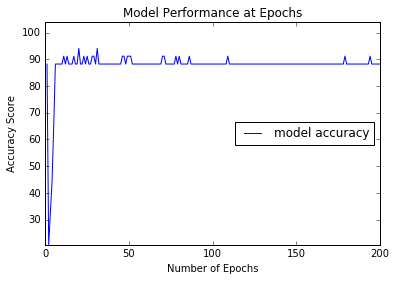

In [10]:
print 'Results of Gradient Descent'
print 'Accuracy scores plotted at each epoch'
linsp = np.linspace(1, numEpochs, numEpochs)
axes = plt.gca()
axes.set_xlim([0, numEpochs])
axes.set_ylim([min(accuracy_SGD), max(accuracy_SGD)+10])
plt.plot(linsp, accuracy_SGD, 'b-', label='model accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy Score')
plt.title('Model Performance at Epochs')
plt.legend(loc='center right')
ix = np.argmax(accuracy_SGD)
print 'epoch with highest accuracy:', ix
print 'score:', round(accuracy_SGD[ix], 3)
for c in range(numCats):
    print 'weights, class', c,  [ round(wi,3) for wi in w_epochs[c][ix] ]

In [11]:
ix = 150
print 'Accuracy score at a selected epoch.' 
print '\nScore at epoch #', ix, ':', 
print round(accuracy_SGD[ix], 3), '\n'
for c in range(numCats):
    print 'weights, class', c, [ round(wi,3) for wi in w_epochs[c][ix] ]

Accuracy score at a selected epoch.

Score at epoch # 150 : 88.235 

weights, class 0 [0.068, 0.642, 1.09, 0.044, -0.934, -0.291, -0.162]
weights, class 1 [0.15, -0.961, -0.385, 0.075, 0.605, 0.641, 0.658]
